In [13]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ioanachichernea","key":"7ca152986b9e37251a1eb2d16c1999b1"}'}

In [17]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           9227        356  1.0              
juhibhojani/house-price                                     House Price                                        7MB  2023-08-02 16:51:21           1058         38  0.9411765        
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          10763        190  1.0              
alphiree/cardiovascular-diseases-ri

In [18]:
dataset_name = 'kunalgupta2616/dog-vs-cat-images-data'
!kaggle datasets download -d 'kunalgupta2616/dog-vs-cat-images-data'

100% 988M/991M [00:11<00:00, 93.9MB/s]
100% 991M/991M [00:11<00:00, 93.3MB/s]


In [19]:
# create a folder to unzip the dataset
folder_name = f"{dataset_name.split('/')[1]}.zip"
print(folder_name)

dog-vs-cat-images-data.zip


In [20]:
!mkdir data_train
!unzip  $folder_name -d data_train

Streaming output truncated to the last 5000 lines.
  inflating: data_train/dogcat/validation/cats/cat.37.jpg  
  inflating: data_train/dogcat/validation/cats/cat.370.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3700.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3701.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3702.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3703.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3704.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3705.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3706.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3707.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3708.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3709.jpg  
  inflating: data_train/dogcat/validation/cats/cat.371.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3710.jpg  
  inflating: data_train/dogcat/validation/cats/cat.3711.jpg  
  inflating: data_train

#### Import Packages

In [21]:
import matplotlib.pyplot as plt

In [22]:
import os
import PIL

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
from keras import layers

In [23]:
!ls


data_train  dog-vs-cat-images-data.zip	kaggle.json  sample_data


#### Create the global Variables

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 3
IMG_SIZE = (180, 180)


train_folder= '/content/data_train/dogcat/train'
val_folder = '/content/data_train/dogcat/validation'
test_folder = '/content/data_train/dogcat/test1'

##### `os.listdir` is a function in Python's built-in os module that returns a list of all the files and directories present in a given directory. It allows you to access the contents of a directory and retrieve the names of all the files and subdirectories within it.

In [25]:
# train

os.listdir(train_folder)
train_c = Path(train_folder + '/cats')
train_d = Path(train_folder + '/dogs')

In [26]:
image_count = len(list(Path(train_folder).glob('*/*.jpg')))
image_count_c = len(list(train_c.glob('**/*.jpg')))
image_count_d = len(list(train_d.glob('**/*.jpg')))
print(image_count_d, image_count_c)

12500 12500


#### Visualize the Data

In [11]:
cats = list(train_c.glob('cat.*'))
dogs = list(train_d.glob('dog.*'))
for image_path in dogs[:5]:
  image = PIL.Image.open(image_path)
  display(image)

NameError: ignored

#### Load Images Using Keras - `tf.keras.utils.image_dataset_from_directory`

In [27]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=Path(train_folder),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=Path(val_folder),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


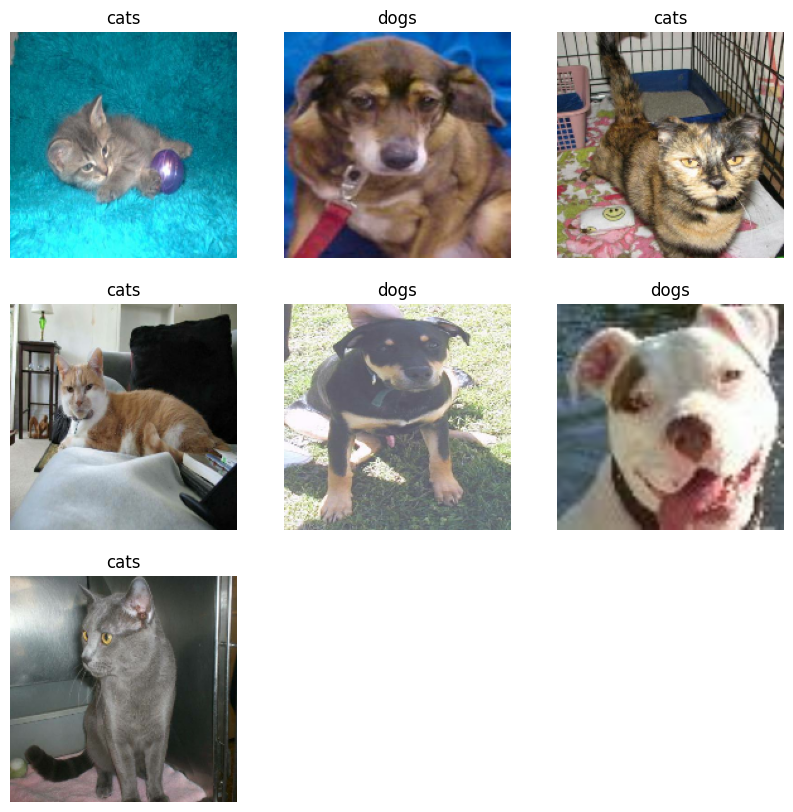

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(2):
  for i in range(7):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Prefetch data -
Buffered prefetching = creating a buffer to store a certain number of data samples in memory while the model is training or evaluating on the previous batch.

Using buffered prefetching to ensure that I/O operations are non-blocking. Blocking I/O refers to the situation when the model has to wait for data to be read from disk before it can continue with computation

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

#### Standardize the Data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

In [30]:
normalization_layer = layers.Rescaling(1./255)

#### Create the Model

In [31]:
num_classes = len(class_names)

In [32]:
model = keras.Sequential(
    layers=  [#ormalize the pixel values of the input images to a range between 0 and 1.
            layers.Rescaling(1./255, input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)),
            # 2D convolutional layer with 16 filters (or output channels) and a filter size of 3x3. The padding='same' argument ensures that the output feature map has the same spatial dimensions as the input, by adding zero-padding around the input image.
            #The activation function used is the Rectified Linear Unit (ReLU) activation, which introduces non-linearity to the model.
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            # Downsampling and Spatial Dimension Reduction: Max pooling layers reduce the spatial dimensions of the features
            #max-pooling layer with a default pool size of 2x2. Max pooling reduces the spatial dimensions of the features, helping to make the model more robust to variations in the input.
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            #This layer is used to flatten the output of the previous convolutional layers into a 1D vector.
            # This is necessary to transition from the convolutional part of the model to the fully connected part.
            layers.Flatten(),
            # This is the final dense (fully connected) layer of the model. The number of neurons in this layer is set to num_classes,
            #which represents the number of classes or categories the model needs to classify
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes)]
)

The architecture is like this:

  layers.Rescaling(1./255, input_shape=(IMG_SIZE + (3,))): The Rescaling layer is used to normalize the pixel values of the input images to a range between 0 and 1. The parameter 1./255 is used to perform this normalization, assuming the original pixel values range from 0 to 255 (typical for RGB images). IMG_SIZE + (3,) is the input shape of the images, where IMG_SIZE represents the desired image size, and (3,) indicates that the images have three color channels (R, G, and B).

layers.Conv2D(16, 3, padding='same', activation='relu'): This is a 2D convolutional layer with 16 filters (or output channels) and a filter size of 3x3. The padding='same' argument ensures that the output feature map has the same spatial dimensions as the input, by adding zero-padding around the input image. The activation function used is the Rectified Linear Unit (ReLU) activation, which introduces non-linearity to the model.

layers.MaxPooling2D(): This is a max-pooling layer with a default pool size of 2x2. Max pooling reduces the spatial dimensions of the features, helping to make the model more robust to variations in the input.

Repeat steps 2 and 3 with increasing number of filters to extract more complex features from the input images. This is a common pattern in CNN architectures.


    Convolutional Part: The convolutional layers (e.g., Conv2D) and pooling layers (e.g., MaxPooling2D) form the convolutional part of the model. They are responsible for extracting features from the input images.

    layers.Flatten(): This layer is used to flatten the output of the convolutional part into a 1D vector. It takes the spatially arranged features from the convolutional layers and converts them into a single long vector. This is necessary to transition from the convolutional part to the fully connected part.

    Fully Connected Part: The fully connected part consists of dense (fully connected) layers (e.g., Dense) where each neuron is connected to every neuron in the previous layer. In the given code snippet, there's a single dense layer: layers.Dense(num_classes). This layer is responsible for performing the final classification based on the learned features from the convolutional part.

To summarize, the "fully connected part" includes the Flatten layer and the Dense layer, which are used to convert the extracted features into a suitable format for classification and perform the final classification, respectively. The convolutional layers before the Flatten layer are responsible for feature extraction from the input images.

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [35]:
epochs = 3
history=model.fit(
    train_ds,
    validation_data = val_ds,
    epochs =epochs
)

Epoch 1/3
625/625 [==============================] - 805s 1s/step - loss: 0.6191 - accuracy: 0.6482 - val_loss: 0.5732 - val_accuracy: 0.6994
Epoch 2/3
625/625 [==============================] - 787s 1s/step - loss: 0.4816 - accuracy: 0.7692 - val_loss: 0.4260 - val_accuracy: 0.8012
Epoch 3/3
625/625 [==============================] - 771s 1s/step - loss: 0.4062 - accuracy: 0.8155 - val_loss: 0.3394 - val_accuracy: 0.8481


In [ ]:
# create model with checkpoints


epochs = 3
history=model.fit(
    train_ds,
    validation_data = val_ds,
    epochs =epochs
)



#### Visualize The Training Results

In [36]:
model.save("catDogZip.keras")


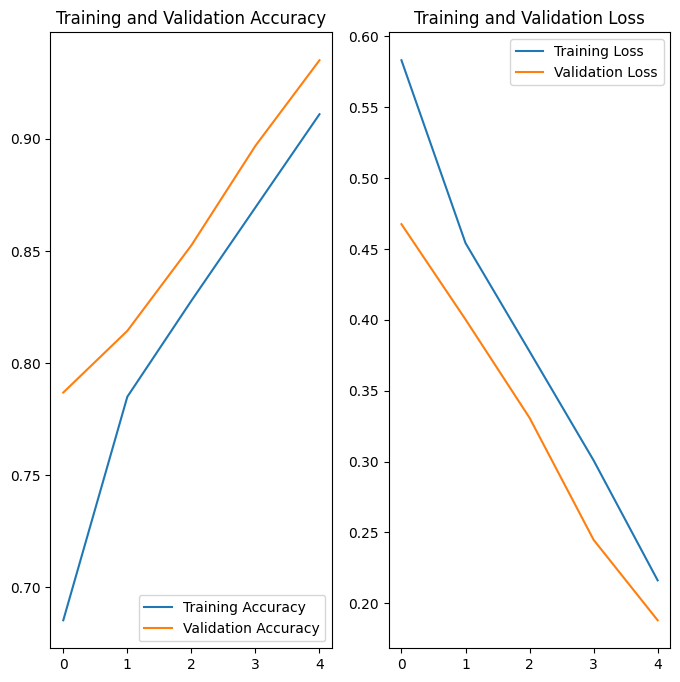

In [ ]:

ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, ACC, label='Training Accuracy')
plt.plot(epochs_range, VAL_ACC, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=Path(test_folder),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
# test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 12500 files belonging to 1 classes.


In [ ]:




loss, acc, prec, rec = model.evaluate(test_ds)





201/391 [==============>...............] - ETA: 1:25 - loss: 2.5261 - accuracy: 0.4555